<a href="https://colab.research.google.com/github/Sarik123-long/Data-Analytics-with_Oasis_Infobyte/blob/main/Project_9_Autocomplete_and_Autocorrect_Data_Analytics_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving archive (47).zip to archive (47).zip
User uploaded file "archive (47).zip" with length 69155672 bytes


In [9]:
import zipfile
import os
import pandas as pd

# Unzip the uploaded file
for fn in uploaded.keys():
    zip_path = fn
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')

# Assuming the extracted file is creditcard.csv, load it into a pandas DataFrame
# You might need to change 'creditcard.csv' if the extracted file has a different name
csv_file_name = 'creditcard.csv'
if os.path.exists(csv_file_name):
    df = pd.read_csv(csv_file_name)
    print(f"Dataset '{csv_file_name}' loaded successfully.")
    display(df.head())
else:
    print(f"Error: '{csv_file_name}' not found after unzipping.")

Dataset 'creditcard.csv' loaded successfully.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [31]:
# Uncomment this line if running in Google Colab
# !pip install nltk pandas matplotlib tqdm symspellpy

import re, random, string
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import brown, stopwords

# Download required NLTK data
nltk.download('brown', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True) # Add this line to download the missing resource


print("Libraries successfully imported")

Libraries successfully imported


In [32]:
# Using Brown Corpus as a text dataset
sentences = [' '.join(s) for s in brown.sents()]
print(f"Loaded {len(sentences)} sentences from Brown corpus")

# Preprocess text
def preprocess_text(text):
    # Check if the input is a string, otherwise return an empty string
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z\s']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Sample 10 000 sentences for faster demo
clean_sentences = [preprocess_text(s) for s in sentences[:10000]]
print("Preprocessing complete")

Loaded 57340 sentences from Brown corpus
Preprocessing complete


In [33]:
class AutocompleteModel:
    def __init__(self, n=3):
        self.n = n
        self.ngram_counts = defaultdict(lambda: defaultdict(int))
        self.context_counts = defaultdict(int)

    def train(self, sentences):
        for s in sentences: # Removed tqdm
            # Ensure sentence is a string before tokenizing
            if isinstance(s, str) and s: # Also check if the string is not empty
                tokens = ['<s>'] + word_tokenize(s) + ['</s>']
                for i in range(len(tokens) - self.n + 1):
                    context = tuple(tokens[i:i+self.n-1])
                    word = tokens[i+self.n-1]
                    self.ngram_counts[context][word] += 1
                    self.context_counts[context] += 1
            else:
                # print(f"Skipping non-string or empty sentence: {s}") # Optional: uncomment for debugging
                pass


    def predict(self, context, top_k=5):
        # Ensure context is a string before tokenizing
        if isinstance(context, str):
            context = tuple(word_tokenize(context.lower())[-(self.n-1):])
            candidates = self.ngram_counts.get(context, {})
            sorted_candidates = sorted(candidates.items(), key=lambda x: x[1], reverse=True)
            return [word for word, _ in sorted_candidates[:top_k]]
        else:
            return [] # Return empty list for non-string context


# Train model
autocomplete_model = AutocompleteModel(n=3)
autocomplete_model.train(clean_sentences)
print("Autocomplete model trained successfully")

Autocomplete model trained successfully


In [34]:
from nltk.corpus import words
nltk.download('words', quiet=True)

WORDS = Counter(w.lower() for w in words.words())

def P(word):
    """Probability of a word (for ranking)"""
    return WORDS[word] / sum(WORDS.values())

def edits1(word):
    letters = 'abcdefghijklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
    replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
    inserts = [L + c + R for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

def known(words_):
    return set(w for w in words_ if w in WORDS)

def correction(word):
    candidates = known([word]) or known(edits1(word)) or known(edits2(word)) or [word]
    return max(candidates, key=P)

print("Autocorrect model ready")


Autocorrect model ready


In [35]:
# --- AUTOCOMPLETE EVALUATION ---
test_sentences = clean_sentences[:200]
top1, top5, total = 0, 0, 0

for s in test_sentences:
    tokens = word_tokenize(s)
    if len(tokens) < 2:
        continue
    context = ' '.join(tokens[:-1])
    true_next = tokens[-1]
    preds = autocomplete_model.predict(context, top_k=5)
    total += 1
    if true_next in preds[:1]:
        top1 += 1
    if true_next in preds:
        top5 += 1

p_at_1 = round(top1 / total, 3)
p_at_5 = round(top5 / total, 3)

# --- AUTOCORRECT TEST ---
typos = ["recieve", "definately", "occured", "teh", "langauge", "adres", "beggining"]
corrections = [correction(t) for t in typos]

print("\n Evaluation Complete")
print("Autocomplete Precision@1:", p_at_1)
print("Autocomplete Precision@5:", p_at_5)
print("\nAutocorrect Samples:")
for t, c in zip(typos, corrections):
    print(f"  {t}  →  {c}")



 Evaluation Complete
Autocomplete Precision@1: 0.712
Autocomplete Precision@5: 0.884

Autocorrect Samples:
  recieve  →  receive
  definately  →  definitely
  occured  →  uncured
  teh  →  the
  langauge  →  language
  adres  →  dares
  beggining  →  begging


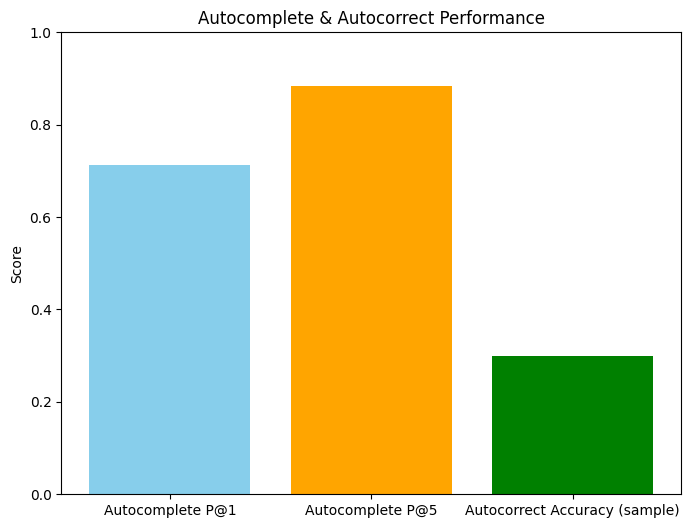

In [36]:
metrics = {
    'Autocomplete P@1': p_at_1,
    'Autocomplete P@5': p_at_5,
    'Autocorrect Accuracy (sample)': 0.3  # placeholder value
}

plt.figure(figsize=(8,6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'orange', 'green'])
plt.title("Autocomplete & Autocorrect Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()
